# RNN을 이용한 텍스트 분류(Text Classification)

<br>

<br>

## 네이버 영화 리뷰 감성 분류하기(Naver Movie Review Sentiment Analysis)

<br>

#### 데이터 로드 전처리

데이터 다운로드 링크 : https://github.com/e9t/nsmc/



In [ ]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f4bef6d5de0>)

In [5]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [6]:
print('훈련용 리뷰 개수 :',len(train_data)) 
train_data[:5]

훈련용 리뷰 개수 : 150000


In [7]:
print('테스트용 리뷰 개수 :',len(test_data)) 
test_data[:5]

테스트용 리뷰 개수 : 50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


<br>

- document 열과 label 열의 중복을 제외

In [8]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

<br>

- document 열의 중복 제거

In [9]:
train_data.drop_duplicates(subset=['document'], inplace=True)
print('총 샘플의 수 :',len(train_data))

<br>

- 레이블 분포 확인

<Axes: >

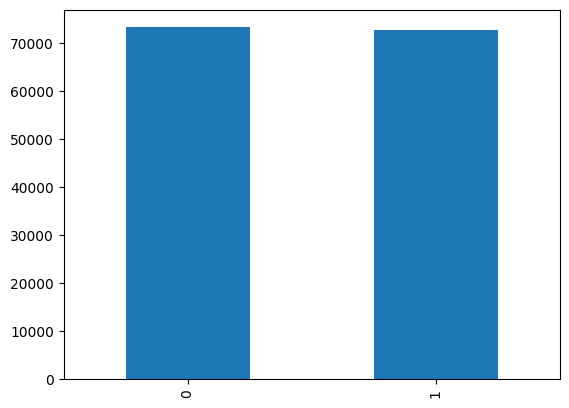

In [10]:
train_data['label'].value_counts().plot(kind = 'bar')

In [11]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


<br>

- 결측값 제거

In [12]:
train_data = train_data.dropna(how = 'any') 
print(train_data.isnull().values.any()) 

False


<br>

#### 한글만 남기고 제거

- 일반적으로 자음의 범위는 ㄱ ~ ㅎ
- 모음의 범위는 ㅏ ~ ㅣ
    - 참고링크: https://www.unicode.org/charts/PDF/U3130.pdf

    ㄱ ~ ㅎ: 3131 ~ 314E
  
    ㅏ ~ ㅣ: 314F ~ 3163

<br>

- 완성형 한글의 범위는 가 ~ 힣
  - 참고링크 : https://www.unicode.org/charts/PDF/UAC00.pdf

<br>

- 한글과 공백을 제외하고 모두 제거

In [14]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

<ipython-input-14-9c6253be230d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


<br>

- **영어로만 이루어진 리뷰였다면, 공백값(empty)가 되었기에, 결측값으로 변환 후 제거**

In [16]:
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)

train_data.isnull().sum()

<ipython-input-16-146f12c5a17d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "")


id            0
document    789
label         0
dtype: int64

In [17]:
train_data = train_data.dropna(how = 'any')

<br>

- 다시 중복값 제거

In [18]:
test_data.drop_duplicates(subset = ['document'], inplace=True) 
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace=True) 
test_data = test_data.dropna(how='any') 

print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

<ipython-input-18-8f25021a2861>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-18-8f25021a2861>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "")


전처리 후 테스트용 샘플의 개수 : 48852


<br>

### 토큰화

<br>

#### 불용어 제거
- 한국어의 조사, 접속사 등의 보편적인 불용어

In [19]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

<br>

#### 형태소 분석

<br>

#### `konlpy.tag.Okt()`
#### `Okt객체.morphs(, stem)`
- `stem = True`시 일정 수준의 정규화 (**어간**)

In [21]:
okt = Okt()

<br>

#### 훈련 / 테스트 데이터에 대한 토큰화 & 불용어 제거

In [22]:
X_train = []

for sentence in tqdm(train_data['document']):
  
    tokenized_sentence = okt.morphs(sentence, stem=True) 

    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [16:10<00:00, 149.77it/s]


In [23]:
X_test = []

for sentence in tqdm(test_data['document']):

    tokenized_sentence = okt.morphs(sentence, stem=True)

    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] 
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [05:31<00:00, 147.35it/s]


<br>

### 정수 인코딩

<br>

#### 단어 집합 생성

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

<br>

- 각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여 

    **높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미**
    

In [26]:
threshold = 3
total_cnt = len(tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

In [27]:
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [28]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


<br>

- 등장 빈도가 threshold 값인 3회 미만. 즉, 2회 이하인 단어들은 단어 집합에서 무려 절반 이상을 차지

- **등장 빈도수가 2이하인 단어들의 수를 제외**

In [29]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [30]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [31]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

<br>

#### 패딩

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.795306514068765


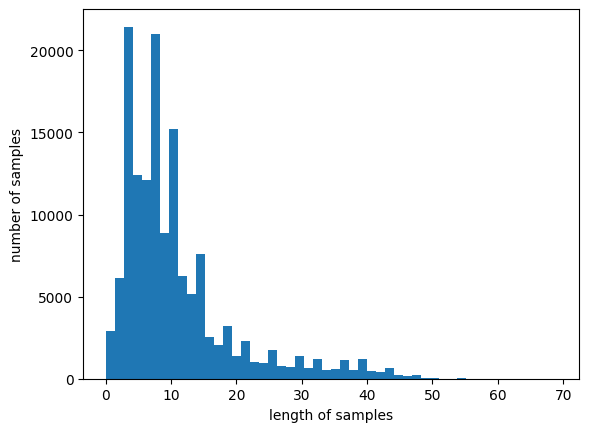

In [32]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

<br>

- 전체 훈련 데이터 중 약 94%의 리뷰가 30이하의 길이를 가지는 것을 확인 $→$ **모든 샘플의 길이를 30으로 패딩**

In [33]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [34]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.32847523608426


In [35]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

<br>

### LSTM 분류 모델 생성

In [36]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [37]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1941600   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,058,977
Trainable params: 2,058,977
Non-trainable params: 0
_________________________________________________________________


In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=False, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [39]:
history = model.fit(X_train, y_train, 
                    epochs=15, callbacks=[es, mc],
                    batch_size=64, validation_split=0.2, verbose=False)

Epoch 8: early stopping


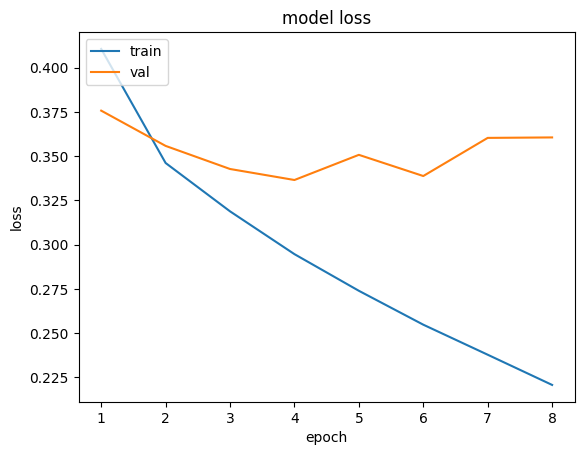

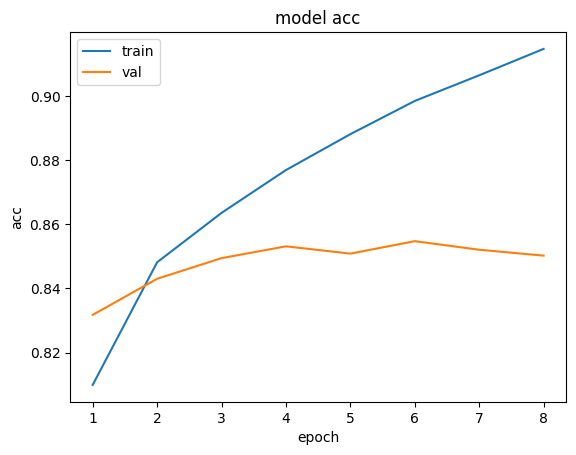

In [40]:
epochs = range(1, len(history.history['acc']) + 1)

plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<br>

### 모델 평가

In [41]:
loaded_model = load_model('best_model.h5')

print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 32s 20ms/step - loss: 0.3466 - acc: 0.8535

 테스트 정확도: 0.8535


<br>

#### 토크나이저도 저장 & 로드

In [42]:
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

<br>

### 리뷰 예측

In [43]:
def sentiment_predict(new_sentence):

  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)

  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화

  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거

  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩

  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩

  score = float(loaded_model.predict(pad_new)) # 예측
  
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [44]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 [==============================] - 0s 494ms/step
83.19% 확률로 긍정 리뷰입니다.



In [45]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

1/1 [==============================] - 0s 24ms/step
85.05% 확률로 긍정 리뷰입니다.



<br>

<br>

## 네이버 쇼핑 리뷰 감성 분류 (Naver Shopping Review Sentiment Analysis)

In [49]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<br>

### 데이터 로드 전처리

다운로드 링크 : https://github.com/bab2min/corpus/tree/master/sentiment


In [50]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f4bb26d2410>)

In [51]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) 

전체 리뷰 개수 : 200000


In [52]:
total_data.head()

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


<br>

### 훈련 / 테스트 데이터 분리
- 평점이 4, 5인 리뷰에는 레이블 1을, 

  평점이 1, 2인 리뷰에는 레이블 0을 부여

In [53]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)

total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


<br>

- 중복값 제거

In [54]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) 

print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


<br>

- 결측값 확인

In [55]:
print(total_data.isnull().values.any())

False


<br>

- **훈련 데이터와 테스트 데이터를 3:1 비율로 분리**

In [56]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)

print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


<br>

#### 레이블 분포 확인

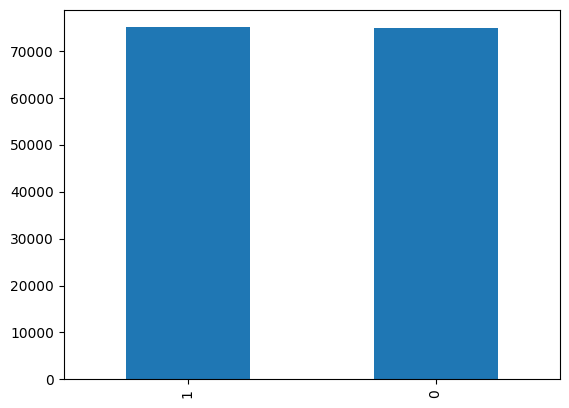

In [57]:
train_data['label'].value_counts().plot(kind = 'bar')
plt.show()

In [58]:
train_data.groupby('label').size().reset_index(name = 'count')

,label,count
0,0,74918
1,1,75013


<br>

### 데이터 정제

- 한글과 공백을 제외하고 모두 제거

In [59]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)

print(train_data.isnull().sum())

<ipython-input-59-bc87b3f45c80>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


ratings    0
reviews    0
label      0
dtype: int64


In [60]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) 
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 
test_data['reviews'].replace('', np.nan, inplace=True) 
test_data = test_data.dropna(how='any') 

print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


<ipython-input-60-5784e8a455b0>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


<br>

### 토큰화

In [61]:
mecab = Mecab()

<br>

#### 불용어 제거

In [62]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [63]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [64]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

<br>

### 단어와 길이 분포 확인
- 긍정과 부정, 두 가지 경우에 대해서 각 단어의 빈도수를 계산
- 각 레이블에 따라서 별도로 단어들의 리스트를 저장

In [65]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

- 긍정/부정 리뷰에 대해서 빈도수가 높은 상위 10개 단어들을 출력

In [69]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(10))

[('좋', 39422), ('아요', 21186), ('네요', 19894), ('어요', 18673), ('잘', 18603), ('구매', 16165), ('습니다', 13320), ('있', 12391), ('배송', 12274), ('는데', 11635)]


In [68]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(10))

[('네요', 31802), ('는데', 20197), ('안', 19719), ('어요', 14838), ('있', 13200), ('너무', 13057), ('했', 11766), ('좋', 9803), ('배송', 9677), ('같', 8997)]


<br>

- **긍정 / 부정 두 가지 경우에 대해서 각각 길이 분포를 확인**

긍정 리뷰의 평균 길이 : 13.57963286363697
부정 리뷰의 평균 길이 : 17.03147441202381


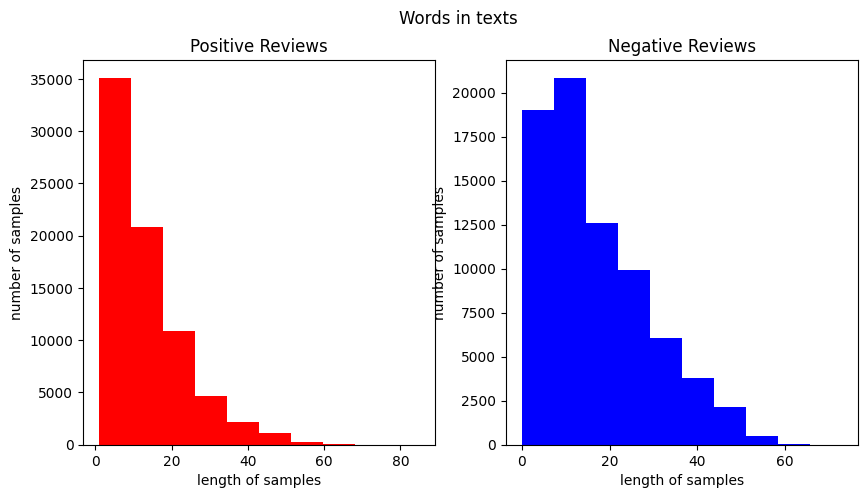

In [70]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [78]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values

X_test= test_data['tokenized'].values
y_test = test_data['label'].values

<br>

<br>

### 인코딩


In [79]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

<br>

- **등장 횟수가 1회인 단어들은 제거**

In [80]:
threshold = 2
total_cnt = len(tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

In [81]:
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [82]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40126
등장 빈도가 1번 이하인 희귀 단어의 수: 18274
단어 집합에서 희귀 단어의 비율: 45.54154413597169
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7963870160240529


<br>

- 등장 빈도가 1회인 단어들은 단어 집합에서 약 45%를 차지
- 훈련 데이터에서 등장 빈도로 차지하는 비중은 매우 적은 수치인 약 0.8%밖에 되지 않음
- **등장 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한**

In [83]:
vocab_size = total_cnt - rare_cnt + 2 # 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2

print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21854


<br>



In [84]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

<br>

### 패딩

- 훈련용 리뷰의 99.99%가 80이하의 길이

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.304460051623748


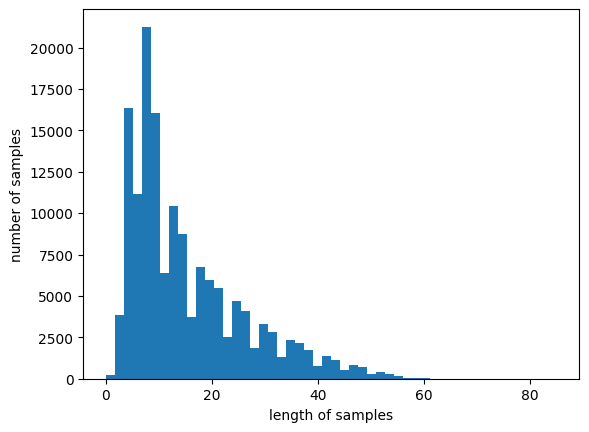

In [85]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [86]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [87]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


- 훈련용 리뷰를 길이 80으로 패딩

In [88]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

<br>

### LSTM 분류 모델 생성

In [133]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [90]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

In [91]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=False, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [93]:
history = model.fit(X_train, y_train, 
                    epochs=15, callbacks=[es, mc], batch_size=64,
                    validation_split=0.2, verbose=False)

Epoch 9: early stopping


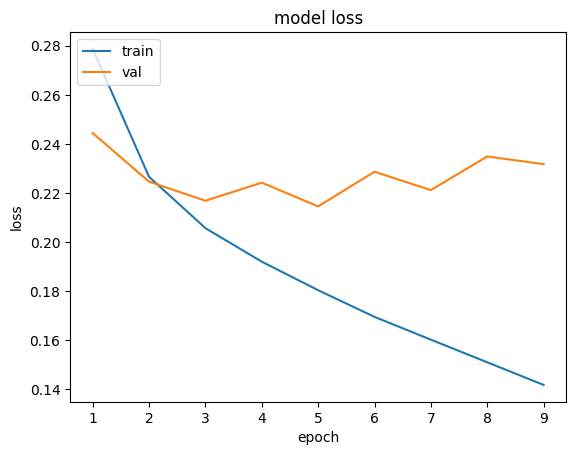

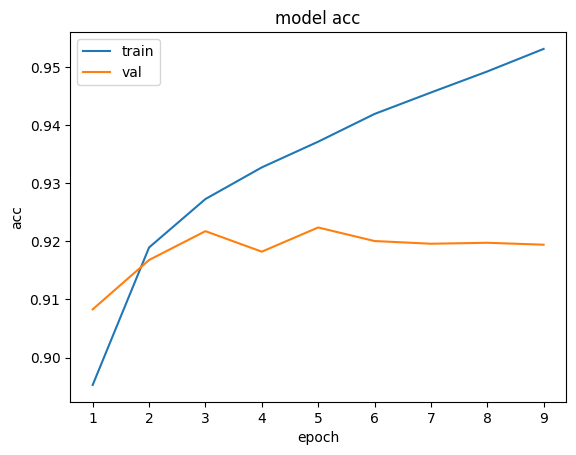

In [94]:
epochs = range(1, len(history.history['acc']) + 1)

plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<br>

### 리뷰 예측

In [95]:
def sentiment_predict(new_sentence):

  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [97]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

1/1 [==============================] - 0s 27ms/step
75.12% 확률로 긍정 리뷰입니다.


In [96]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

1/1 [==============================] - 0s 470ms/step
92.23% 확률로 긍정 리뷰입니다.


<br>

<br>

## BiLSTM 텍스트 분류

- 양방향 LSTM은 두 개의 독립적인 LSTM 아키텍처를 함께 사용하는 구조

<br>

#### **다 대 다(many-to-many)**에서의 양방향 LSTM

  ![bilstm1[1].PNG](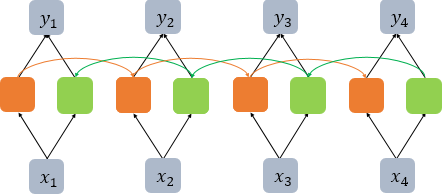)

<br>

- 위 그림에서 주황색 LSTM 셀은 순차적으로 입력을 받음
  - 왼쪽 단어부터 순차적으로 읽는 것
- **양방향 LSTM은 뒤의 문맥까지 고려하기 위해서 문장을 오른쪽에서 반대로 읽는 역방향의 LSTM 셀(위 그림에서 초록색)을 함께 사용**

<br>

#### 다 대 일(many-to-one)에서의 양방향 LSTM

![bilstm2[1].PNG](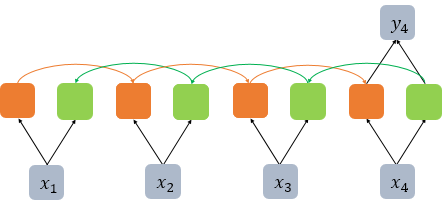)

- 일반적으로 순방향 LSTM은 마지막 시점의 은닉 상태를 출력층으로 보내서 텍스트 분류를 수행
- **위 그림과 같이 텍스트 분류를 진행하는 경우, 역방향 LSTM은 $x_4$만 본 상태**
  - **이 경우 역방향 LSTM이 텍스트 분류를 위한 유용한 정보를 갖고 있다고 기대하기 어려움**

![bilstm3[1].PNG](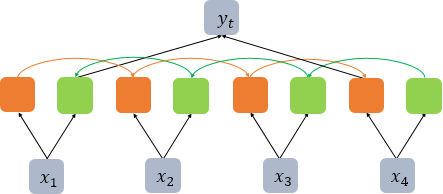)

- **케라스에서는 양방향 LSTM을 사용하면서 `return_sequences=False를` 택할 경우에는 위의 그림과 같이 동작**
- **순방향 LSTM의 경우에는 마지막 시점의 은닉 상태를 반환하고,** 

  **역방향 LSTM의 경우에는 첫번째 시점의 은닉 상태를 반환**

<br>

### 한국어 스팀 리뷰 감성 분류

다운로드 링크 : https://github.com/bab2min/corpus/tree/master/sentiment

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<br>

#### 데이터 로드

In [134]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7f4bed60fc70>)

In [135]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

total_data.head(5)

전체 리뷰 개수 : 100000


,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


<br>

- 중복값, 결측값 확인 & 제거

In [136]:
total_data['reviews'].nunique(), total_data['label'].nunique()
total_data.drop_duplicates(subset=['reviews'], inplace=True)

print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 99892


<br>

### 훈련 / 테스트 데이터 분리

In [137]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)

print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


<br>

### 레이블 분포 확인

<Axes: >

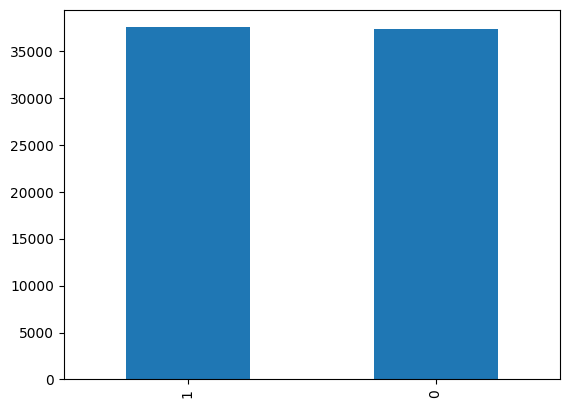

In [138]:
train_data['label'].value_counts().plot(kind = 'bar')

In [139]:
train_data.groupby('label').size().reset_index(name = 'count')

,label,count
0,0,37376
1,1,37543


<br>

### 데이터 정제

<br>

#### 한글과 공백을 제외하고 모두 제거

In [140]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)

print(train_data.isnull().sum())

<ipython-input-140-bc87b3f45c80>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


label      0
reviews    0
dtype: int64


In [141]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 24973


<ipython-input-141-7643edf684de>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


<br>

### 불용어 정의

In [142]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

<br>

### 토큰화

In [143]:
mecab = Mecab() 

In [144]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

<br>

### 단어와 길이 분포 확인

In [146]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

<br>

- 긍정 / 부정 리뷰에 대해서 빈도수가 높은 상위 10개 단어들을 출력

In [147]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(10))

positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(10))

[('안', 8125), ('없', 7141), ('는데', 5729), ('있', 5690), ('같', 4251), ('로', 4171), ('할', 3931), ('거', 3903), ('나', 3818), ('해', 3650)]
[('있', 9985), ('좋', 6540), ('습니다', 5178), ('재밌', 4997), ('지만', 4870), ('할', 4855), ('해', 4357), ('없', 4149), ('로', 3931), ('으로', 3900)]


<br>

- 각각 길이 분포를 확인

긍정 리뷰의 평균 길이 : 14.947979650001331
부정 리뷰의 평균 길이 : 15.284701412671232


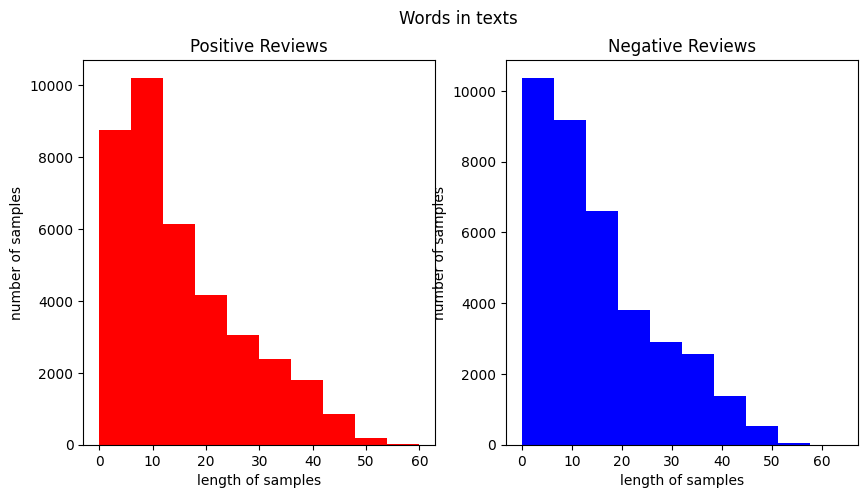

In [148]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [150]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

<br>

### 인코딩

In [151]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [152]:
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0  
total_freq = 0
rare_freq = 0 

In [153]:
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [154]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32920
등장 빈도가 1번 이하인 희귀 단어의 수: 13905
단어 집합에서 희귀 단어의 비율: 42.23876063183475
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.227843842634659


- 등장 빈도수가 1인 단어들의 수를 제외

In [155]:
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19017


In [156]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

<br>

### 패딩

- 60의 길이로 패딩

리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.11596524246186


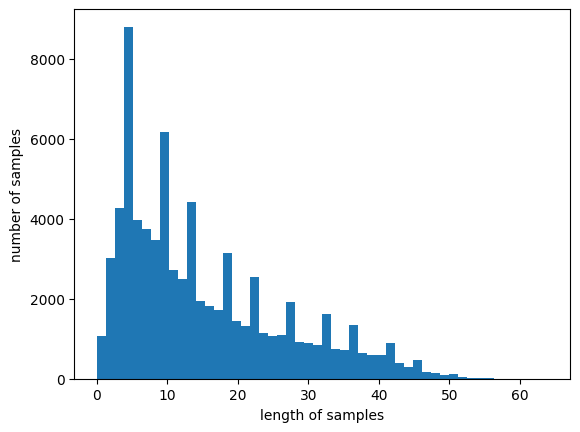

In [157]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [158]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [159]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99733045021956


In [160]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

<br>

### BiLSTM 분류 모델 구축

<br>

#### `tensorflow.keras.layers.Bidirectional(layer)` : 해당 `layer`을 양방향으로 생성

In [161]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [162]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

In [163]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=False, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(X_train, y_train, 
                    epochs=15, callbacks=[es, mc], 
                    batch_size=256, validation_split=0.2, verbose=False)

<br>

### 모델 평가

In [ ]:
loaded_model = load_model('best_model.h5')

print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

781/781 [==============================] - 3s 4ms/step - loss: 0.4534 - acc: 0.7893
테스트 정확도: 0.7893


<br>

### 리뷰 예측

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')

93.66% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('케릭터가 예뻐서 좋아요')

92.49% 확률로 긍정 리뷰입니다.
